### Predicting Pokemon stats with ML on expanded data

In this notebook we train an XGBoost model to predict one of the Pokemon stats given the other stats, the Pokemon type, and whether the Pokemon is Legendary.

To try to improve the model, we add new features of fractions of other stats and the sum of the other stats.

In this file we also use a larger dataset. We found that the extra features present here, namely catch rate and height and weight, do not seem helpful to predict any stat. This dataset does include extra Pokemon though, from Gen 7, so this data may lead to better results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.optimize import curve_fit

In [11]:
# Prepare the data, like in the exploration notebook; we now also drop the height, weight and capture rate columns
data = pd.read_csv('../../data/poke_data/Pokemon_expanded.csv')
data = data.drop(columns=['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'base_egg_steps', 'base_happiness',
       'classfication', 'experience_growth', 'japanese_name', 'percentage_male',
       'height_m', 'weight_kg', 'capture_rate'])
data = data.rename(columns={'attack': 'Attack', 'defense': 'Defense', 'sp_attack': 'Sp. Atk',
                            'sp_defense': 'Sp. Def', 'speed': 'Speed', 'type1': 'Type 1',
                            'type2': 'Type 2', 'base_total': 'Total', 'hp': 'HP', 'name': 'Name',
                            'generation': 'Generation', 'is_legendary': 'Legendary', 'pokedex_number': '#'})
data = data[['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
             'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']]
data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,grass,poison,318,45,49,49,65,65,45,1,0
1,2,Ivysaur,grass,poison,405,60,62,63,80,80,60,1,0
2,3,Venusaur,grass,poison,625,80,100,123,122,120,80,1,0
3,4,Charmander,fire,NaN,309,39,52,43,60,50,65,1,0
4,5,Charmeleon,fire,NaN,405,58,64,58,80,65,80,1,0


In [12]:
print("Data shape:", data.shape)
print("Previous data shape:", pd.read_csv('../../data/poke_data/Pokemon.csv').shape)

Data shape: (801, 13)
Previous data shape: (800, 13)


In [13]:
# Add the Mega Evolutions from the other dataset
data_megas = pd.read_csv('../../data/poke_data/Pokemon.csv')

# Filter to get only Mega Evolutions
data_megas = data_megas[data_megas['Name'].str.contains('Mega ')]  # add the space to circumvent 'Meganium'

# Set Legendary to to 0 or 1
data_megas['Legendary'] = data_megas['Legendary'].map({False: 0, True: 1})
# Make types all lowercase
data_megas['Type 1'] = data_megas['Type 1'].str.lower()
data_megas['Type 2'] = data_megas['Type 2'].str.lower()

# Add a 'Mega' column to indicate these are Mega Evolutions, it might be useful
data_megas['Mega'] = 1
data_megas.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Mega
3,3,VenusaurMega Venusaur,grass,poison,625,80,100,123,122,120,80,1,0,1
7,6,CharizardMega Charizard X,fire,dragon,634,78,130,111,130,85,100,1,0,1
8,6,CharizardMega Charizard Y,fire,flying,634,78,104,78,159,115,100,1,0,1
12,9,BlastoiseMega Blastoise,water,NaN,630,79,103,120,135,115,78,1,0,1
19,15,BeedrillMega Beedrill,bug,poison,495,65,150,40,15,80,145,1,0,1


In [14]:
# For the original dataset, we set Mega to 0
data['Mega'] = 0

# Concatenate the two datasets
data = pd.concat([data, data_megas], ignore_index=True)
print("Combined data shape:", data.shape)
# Note that other than Mega Evolutions, the other dataset also contains some different forms of Pokemon which gave it extra entries
# It's hard to isolate these though, so we won't add those here

Combined data shape: (849, 14)


In [15]:
# First drop the number, Name, Total, and Generation columns
data = data.drop(columns=['#', 'Name', 'Total', 'Generation'])

# One-hot encode the Type 1 and Type 2 columns
data = data.fillna('None')  # Fill NaN values in Type columns with 'None'
data = pd.get_dummies(data, columns=['Type 1', 'Type 2'], drop_first=False)
data.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Mega,Type 1_bug,Type 1_dark,...,Type 2_ghost,Type 2_grass,Type 2_ground,Type 2_ice,Type 2_normal,Type 2_poison,Type 2_psychic,Type 2_rock,Type 2_steel,Type 2_water
0,45,49,49,65,65,45,0,0,False,False,...,False,False,False,False,False,True,False,False,False,False
1,60,62,63,80,80,60,0,0,False,False,...,False,False,False,False,False,True,False,False,False,False
2,80,100,123,122,120,80,0,0,False,False,...,False,False,False,False,False,True,False,False,False,False
3,39,52,43,60,50,65,0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,58,64,58,80,65,80,0,0,False,False,...,False,False,False,False,False,False,False,False,False,False


Now try to predict the Attack stat

In [16]:
# Split the data into features and target variable
X = data.drop(columns=['Attack'])
y = data['Attack']

# Add to X the fractions of each stat, like Defense/HP, making sure we don't also add HP/Defense
feature_stats = ['HP', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for i, stat_1 in enumerate(feature_stats):
    for stat_2 in feature_stats[i+1:]:
        X[f'{stat_1}/{stat_2}'] = X[stat_1] / X[stat_2]

# Also add the sum of these stats (not including Attack!), as an indicator of overall strength
X['Stat_Sum'] = X[feature_stats].sum(axis=1)

X.head()

,HP,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Mega,Type 1_bug,Type 1_dark,Type 1_dragon,...,HP/Sp. Atk,HP/Sp. Def,HP/Speed,Defense/Sp. Atk,Defense/Sp. Def,Defense/Speed,Sp. Atk/Sp. Def,Sp. Atk/Speed,Sp. Def/Speed,Stat_Sum
0,45,49,65,65,45,0,0,False,False,False,...,0.692308,0.692308,1.000,0.753846,0.753846,1.088889,1.000000,1.444444,1.444444,269
1,60,63,80,80,60,0,0,False,False,False,...,0.750000,0.750000,1.000,0.787500,0.787500,1.050000,1.000000,1.333333,1.333333,343
2,80,123,122,120,80,0,0,False,False,False,...,0.655738,0.666667,1.000,1.008197,1.025000,1.537500,1.016667,1.525000,1.500000,525
3,39,43,60,50,65,0,0,False,False,False,...,0.650000,0.780000,0.600,0.716667,0.860000,0.661538,1.200000,0.923077,0.769231,257
4,58,58,80,65,80,0,0,False,False,False,...,0.725000,0.892308,0.725,0.725000,0.892308,0.725000,1.230769,1.000000,0.812500,341


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
lr_tests = [0.01, 0.05, 0.06, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.3]
for lr in lr_tests:
    model = XGBRegressor(n_estimators=1000, learning_rate=lr, random_state=42, early_stopping_rounds=5)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Estimators used: {model.best_iteration}')
    print(f'Learning Rate: {lr}, RMSE: {rmse:.2f}')
    print()

Estimators used: 543
Learning Rate: 0.01, RMSE: 22.41

Estimators used: 116
Learning Rate: 0.05, RMSE: 22.42

Estimators used: 105
Learning Rate: 0.06, RMSE: 22.25

Estimators used: 85
Learning Rate: 0.08, RMSE: 22.15

Estimators used: 71
Learning Rate: 0.09, RMSE: 22.07

Estimators used: 60
Learning Rate: 0.1, RMSE: 22.15

Estimators used: 70
Learning Rate: 0.11, RMSE: 22.34

Estimators used: 65
Learning Rate: 0.12, RMSE: 21.83

Estimators used: 64
Learning Rate: 0.13, RMSE: 22.83

Estimators used: 61
Learning Rate: 0.14, RMSE: 22.23

Estimators used: 35
Learning Rate: 0.15, RMSE: 22.78

Estimators used: 33
Learning Rate: 0.2, RMSE: 22.84

Estimators used: 23
Learning Rate: 0.3, RMSE: 22.36



It looks like the extra data does help, as the lowest error is now 21.83 for a learning rate of 0.12. This is also a fair bit better than we found before.

Let's check feature importance: there we see the added Mega feature is also fairly helpful.

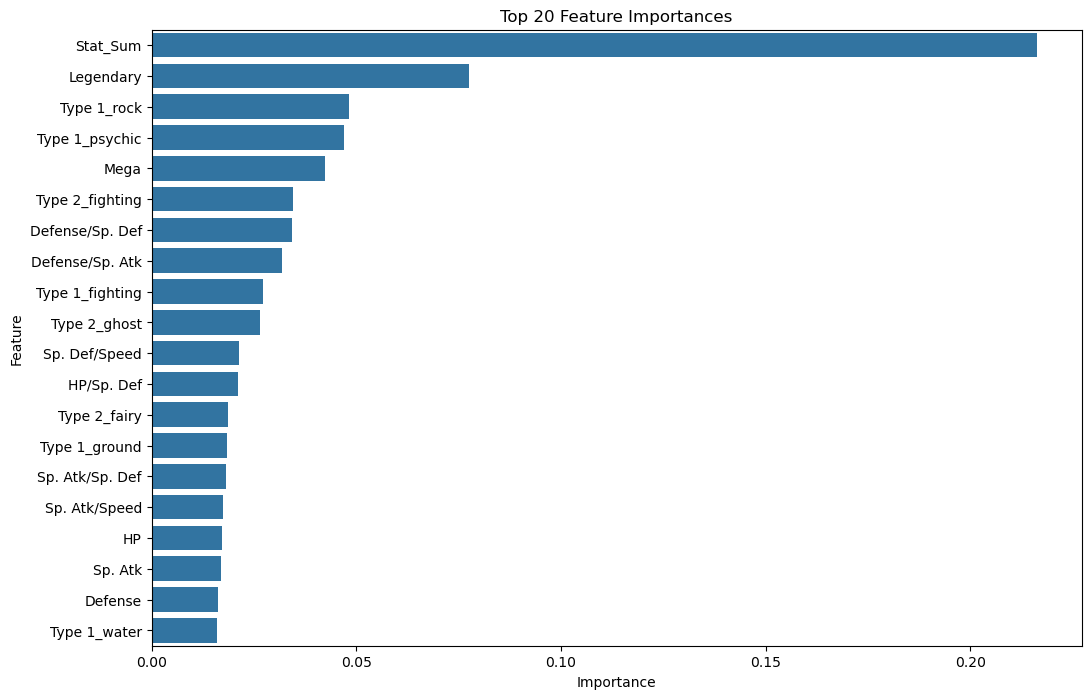

In [19]:
feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [20]:
# Try only important features
importance_df = importance_df[importance_df['Importance'] >= 0.01]
important_features = importance_df['Feature'].tolist()
X_important = X[important_features]
X_important.head()

,Stat_Sum,Legendary,Type 1_rock,Type 1_psychic,Mega,Type 2_fighting,Defense/Sp. Def,Defense/Sp. Atk,Type 1_fighting,Type 2_ghost,...,Type 2_fire,Speed,Type 2_dark,HP/Sp. Atk,Type 1_normal,Defense/Speed,Type 1_dragon,Type 2_flying,Type 1_ghost,Type 1_fire
0,269,0,False,False,0,False,0.753846,0.753846,False,False,...,False,45,False,0.692308,False,1.088889,False,False,False,False
1,343,0,False,False,0,False,0.787500,0.787500,False,False,...,False,60,False,0.750000,False,1.050000,False,False,False,False
2,525,0,False,False,0,False,1.025000,1.008197,False,False,...,False,80,False,0.655738,False,1.537500,False,False,False,False
3,257,0,False,False,0,False,0.860000,0.716667,False,False,...,False,65,False,0.650000,False,0.661538,False,False,False,True
4,341,0,False,False,0,False,0.892308,0.725000,False,False,...,False,80,False,0.725000,False,0.725000,False,False,False,True


In [23]:
X_important_train, X_important_test, y_important_train, y_important_test = train_test_split(X_important, y, test_size=0.25, random_state=42)

for lr in lr_tests:
    model = XGBRegressor(n_estimators=1000, learning_rate=lr, random_state=42, early_stopping_rounds=5)
    model.fit(X_important_train, y_important_train, eval_set=[(X_important_test, y_important_test)], verbose=False)
    y_pred = model.predict(X_important_test)
    rmse = np.sqrt(mean_squared_error(y_important_test, y_pred))
    print(f'Estimators used: {model.best_iteration}')
    print(f'Learning Rate: {lr}, RMSE: {rmse:.2f}')
    print()

Estimators used: 554
Learning Rate: 0.01, RMSE: 22.26

Estimators used: 125
Learning Rate: 0.05, RMSE: 21.84

Estimators used: 82
Learning Rate: 0.06, RMSE: 22.12

Estimators used: 83
Learning Rate: 0.08, RMSE: 22.04

Estimators used: 54
Learning Rate: 0.09, RMSE: 22.44

Estimators used: 62
Learning Rate: 0.1, RMSE: 22.06

Estimators used: 51
Learning Rate: 0.11, RMSE: 22.24

Estimators used: 54
Learning Rate: 0.12, RMSE: 22.56

Estimators used: 39
Learning Rate: 0.13, RMSE: 22.93

Estimators used: 51
Learning Rate: 0.14, RMSE: 22.37

Estimators used: 34
Learning Rate: 0.15, RMSE: 22.30

Estimators used: 31
Learning Rate: 0.2, RMSE: 22.40

Estimators used: 16
Learning Rate: 0.3, RMSE: 22.54



Here we see that the results don't improve this way, as the best error is 21.84, 0.01 higher than before.

Now also see if the linear correction trick can improve the best result with all features as well.

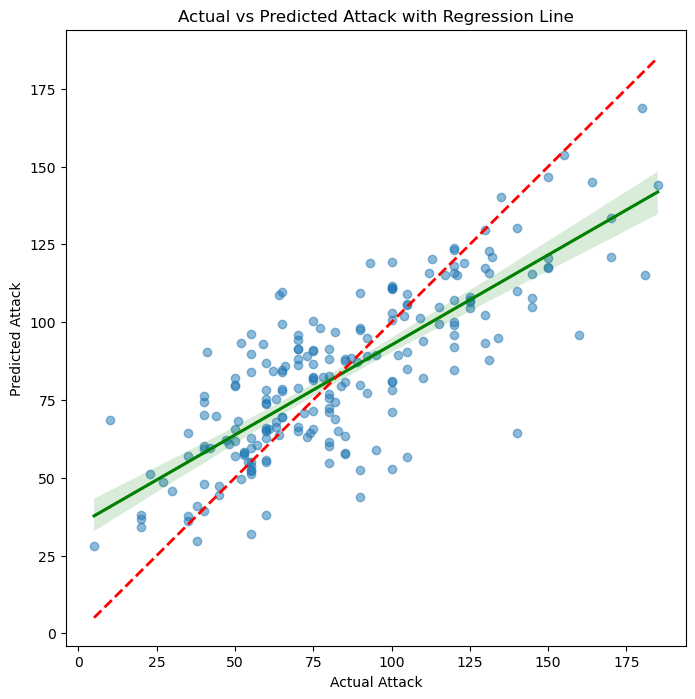

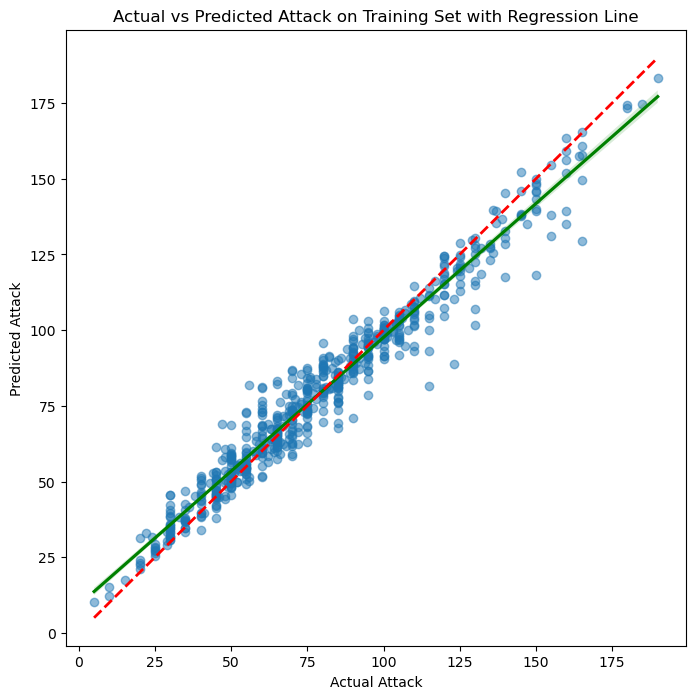

In [26]:
model_best = XGBRegressor(n_estimators=1000, learning_rate=0.12, random_state=42, early_stopping_rounds=5)
model_best.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = model_best.predict(X_test)

plt.figure(figsize=(8, 8))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line, perfect prediction line
plt.xlabel('Actual Attack')
plt.ylabel('Predicted Attack')
plt.title('Actual vs Predicted Attack with Regression Line')
plt.show()

y_train_pred = model_best.predict(X_train)
plt.figure(figsize=(8, 8))
sns.regplot(x=y_train, y=y_train_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # Diagonal line, perfect prediction line
plt.xlabel('Actual Attack')
plt.ylabel('Predicted Attack')
plt.title('Actual vs Predicted Attack on Training Set with Regression Line')
plt.show()

Final linear model parameters: a=1.0824, b=-6.5469
RMSE after correction: 21.70


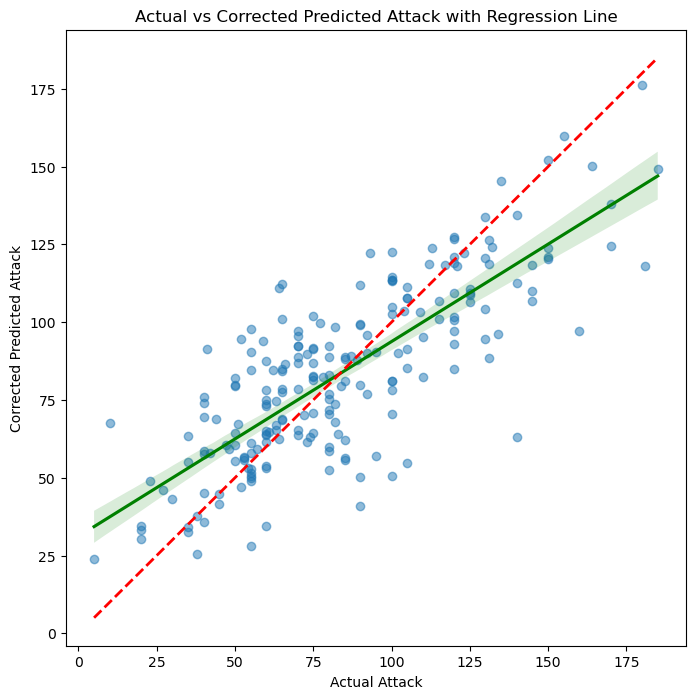

In [29]:
# Apply the fit
def linear_model(x, a, b):
    return a * x + b

params_final, _ = curve_fit(linear_model, y_train_pred, y_train)
print(f'Final linear model parameters: a={params_final[0]:.4f}, b={params_final[1]:.4f}')

y_pred_corrected = linear_model(y_pred, *params_final)
rmse_corrected = np.sqrt(mean_squared_error(y_test, y_pred_corrected))
print(f'RMSE after correction: {rmse_corrected:.2f}')

plt.figure(figsize=(8, 8))
sns.regplot(x=y_test, y=y_pred_corrected, scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line, perfect prediction line
plt.xlabel('Actual Attack')
plt.ylabel('Corrected Predicted Attack')
plt.title('Actual vs Corrected Predicted Attack with Regression Line')
plt.show()

So like before, the linear correction makes the predictions slightly better but does not fully solve the problem.

To conclude, we achieve an error of 21.70 here, which really is not that much better than the easily trained model with an error of about 24. It's still nice to see some improvement though.

As remarked previously, there might be a possibility to improve the model by adding more features. For instance the evolutionary stage of a Pokemon; an evolved Pokemon is generally stronger and this could serve as an indicator of overall stat magnitude. (One would have to manually add this information for every Pokemon though, a fair bit of work.)
Adding even more data also seems like it would help, as there are more Pokemon in the games than in this dataset (up to Gen 9, with 1025 Pokemon, excluding Megas and other forms).